In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# --- 1. Data Loading and Preparation ---
file_path = "datasets/cleaned/merged_fx_dataset.csv"
data = pd.read_csv(file_path)

In [2]:
# Convert 'Date' to datetime and set as index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.sort_index(inplace=True)

# Select the 'Buying' price series and clean
buying_price = data['Buying'].copy()

In [3]:
buying_price

Date
2008-01-02     0.9545
2008-01-03     0.9545
2008-01-04     0.9543
2008-01-07     0.9551
2008-01-08     0.9576
               ...   
2022-11-25    13.0985
2022-11-28    13.0982
2022-11-29    13.0980
2022-11-30    13.0978
2022-12-01    13.0973
Name: Buying, Length: 3703, dtype: float64

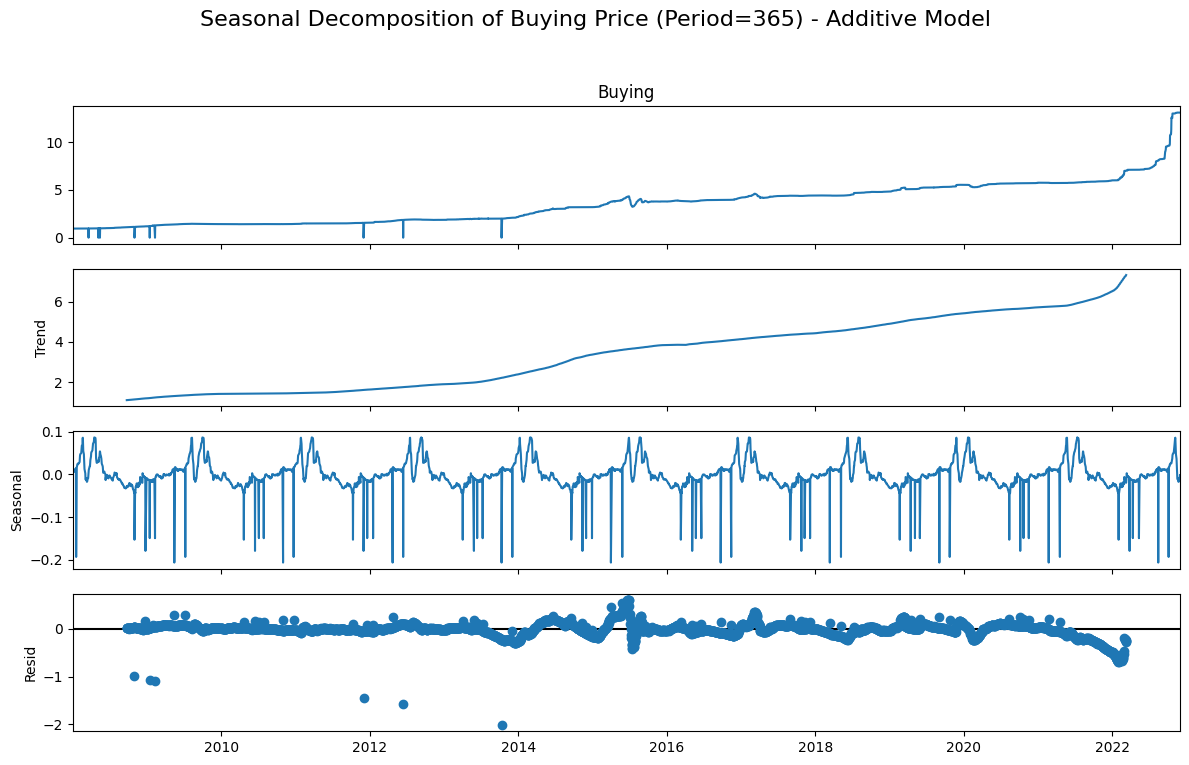

In [4]:
try:
    # Use Additive model due to presence of zero value and for robustness
    decomposition = seasonal_decompose(
        buying_price, model='additive', period=365)

    fig = decomposition.plot()
    fig.set_size_inches(12, 8)
    fig.suptitle(
        'Seasonal Decomposition of Buying Price (Period=365) - Additive Model', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    # plt.savefig('seasonal_decomposition.png')
    plt.show()
    # plt.close(fig)
except Exception as e:
    print(f"Seasonal Decomposition failed: {e}")

In [5]:
def check_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    return result # Return p-value

In [6]:
stationarity_results = check_stationarity(buying_price)

print("ADF Statistic: {:.4f}".format(stationarity_results[0]))
print("p-value: {:.4f}".format(stationarity_results[1]))
for key, value in stationarity_results[4].items():
    print(f'Critical Value {key}: {value:.4f}')

ADF Statistic: 3.3008
p-value: 1.0000
Critical Value 1%: -3.4321
Critical Value 5%: -2.8623
Critical Value 10%: -2.5672


In [7]:
stationary_series = buying_price.copy()
d = 0
while adfuller(stationary_series.dropna())[1] > 0.05:
    stationary_series = stationary_series.diff().dropna()
    d += 1
    adf_test_post = adfuller(stationary_series)
    print(f'\nAfter {d} differencing(s):')
    print("ADF Statistic: {:.4f}".format(adf_test_post[0]))
    print("p-value: {:.4f}".format(adf_test_post[1]))

print(f"\nNumber of differences (d) needed for stationarity: {d}")


After 1 differencing(s):
ADF Statistic: -9.1546
p-value: 0.0000

Number of differences (d) needed for stationarity: 1


In [8]:
stationary_series

Date
2008-01-03    0.0000
2008-01-04   -0.0002
2008-01-07    0.0008
2008-01-08    0.0025
2008-01-09   -0.0002
               ...  
2022-11-25   -0.0002
2022-11-28   -0.0003
2022-11-29   -0.0002
2022-11-30   -0.0002
2022-12-01   -0.0005
Name: Buying, Length: 3702, dtype: float64

In [9]:
d

1

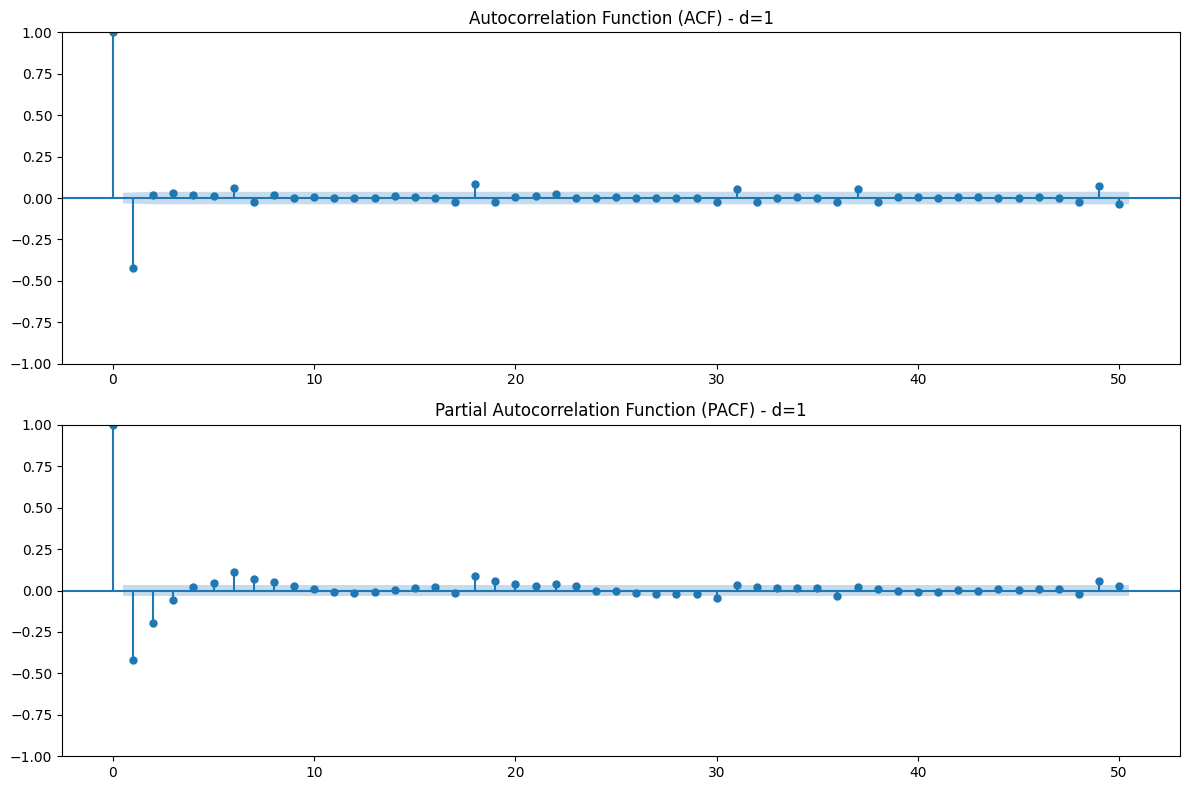

In [10]:
# --- 4. Plot ACF and PACF ---
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# ACF plot
plot_acf(stationary_series, lags=50, ax=axes[0])
axes[0].set_title(f'Autocorrelation Function (ACF) - d={d}')

# PACF plot
plot_pacf(stationary_series, lags=50, ax=axes[1], method='ywm')
axes[1].set_title(f'Partial Autocorrelation Function (PACF) - d={d}')

plt.tight_layout()
# plt.savefig('acf_pacf_plots.png')
# plt.close(fig)
plt.show()

In [11]:
buying_price.tail()

Date
2022-11-25    13.0985
2022-11-28    13.0982
2022-11-29    13.0980
2022-11-30    13.0978
2022-12-01    13.0973
Name: Buying, dtype: float64

In [12]:
# --- 5. Train ARIMA Model and Forecast ---
# Split data into training and testing sets (90% train, 10% test)
train_size = int(len(buying_price) * 0.9)
train_data, test_data = buying_price[:train_size], buying_price[train_size:]

# ARIMA order (p, d, q) determined as (1, 1, 1)
p=1
d=d
q=1
order = (p, d, q)

In [13]:
print(f'Order for ARIMA model = {order}')

Order for ARIMA model = (1, 1, 1)


In [17]:
# Fit the ARIMA model
model = ARIMA(train_data, order=order)
model_fit = model.fit()

/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [19]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Buying   No. Observations:                 3332
Model:                 ARIMA(1, 1, 1)   Log Likelihood                3608.830
Date:                Sat, 25 Oct 2025   AIC                          -7211.659
Time:                        12:18:00   BIC                          -7193.326
Sample:                             0   HQIC                         -7205.100
                               - 3332                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0554      0.006     -9.467      0.000      -0.067      -0.044
ma.L1         -0.6870      0.005   -128.847      0.000      -0.697      -0.677
sigma2         0.0067   1.38e-05    485.272      0.000       0.007       0.007
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):          11698232.71
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                           -14.07
Prob(H) (two-sided):                  0.00   Kurtosis:                       291.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:


# Forecast the values for the test period
steps = len(test_data)
forecast = model_fit.forecast(steps=steps)

# Align the forecast with the test data index
forecast_series = pd.Series(forecast.values, index=test_data.index)

/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be g

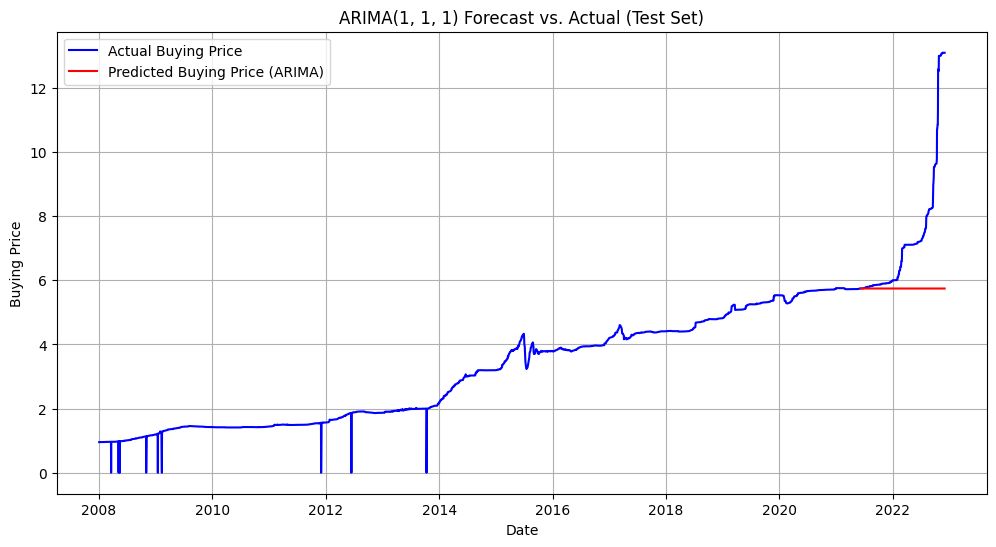

In [15]:
# Plotting Actual vs. Predicted values
plt.figure(figsize=(12, 6))
plt.plot(buying_price, label='Actual Buying Price', color='blue')
plt.plot(forecast_series, label='Predicted Buying Price (ARIMA)', color='red')
plt.title(f'ARIMA{order} Forecast vs. Actual (Test Set)')
plt.xlabel('Date')
plt.ylabel('Buying Price')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('gemini_arima_predictions.png')
plt.close()

In [16]:
# --- 6. Evaluate Predictions ---
mae = mean_absolute_error(test_data, forecast_series)
mse = mean_squared_error(test_data, forecast_series)
rmse = np.sqrt(mse)
r2 = r2_score(test_data, forecast_series)

results_df = pd.DataFrame({
    'Model': ['ARIMA'],
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse],
    'R2': [r2]
})

results_df

,Model,MAE,MSE,RMSE,R2
0,ARIMA,1.546437,6.537039,2.556763,-0.576873


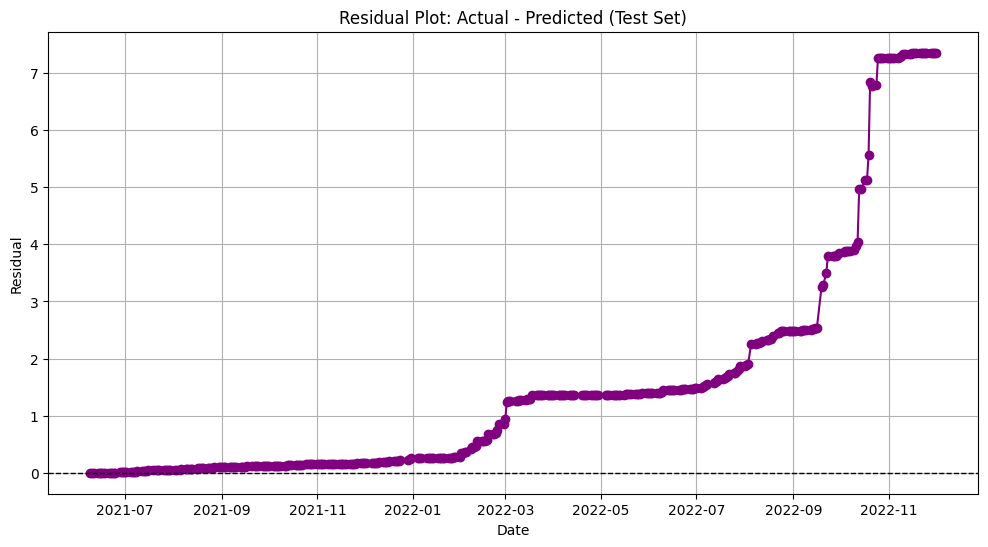

In [20]:
# Generate residuals for the test set
residuals = test_data - forecast_series

# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals, marker='o', linestyle='-', color='purple')
plt.title('Residual Plot: Actual - Predicted (Test Set)')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.grid(True)
plt.show()
plt.savefig('gemini_arima_residuals.png')
plt.close()
